In [1]:
import numpy as np
import sys
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from classevy import StudentGroup, Klas, Plan
from optime import child, Population

In [2]:
students = StudentGroup('../data/students_evy.csv')
students

,name,gender,score_spelling,score_wiskunde,zorg,klimop,zone_gedrag,not_together,together,preferences
number,,,,,,,,,,
1,Younes,1,5,5,1,0,0,"(4,)","(2,)","(3, 6, 17)"
2,Dieuwke,-1,4,4,0,0,0,(),"(1,)","(5, 9, 20)"
3,Arthur,1,5,1,1,0,0,"(6,)",(),"(2, 1, 21)"
4,Wout,1,2,1,0,0,0,"(1,)",(),"(5, 6, 7)"
5,Amelia,-1,2,4,0,0,0,(),(),"(6, 7, 22)"
6,Anna,-1,3,1,0,0,0,"(3, 8)",(),"(12, 5, 23)"
7,Helena,-1,2,2,0,0,0,(),"(8,)","(8, 17, 23)"
8,Denzel,1,3,2,0,0,0,"(6,)","(7,)","(9, 20, 14)"
9,Ties,1,5,3,1,0,0,(),(),"(10, 18, 19)"


In [3]:
plans = [Plan(students, 2) for _ in np.arange(20)]

In [4]:
print(plans[0].assignment)
print(plans[1].assignment)

[0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0]
[1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0]


In [5]:
print(plans[0].final_assignment)
print(plans[1].final_assignment)

[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
[1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


With a given list of students, there's only so much you can do. I.e. if there's an odd number of students and an even number of classes, then you can't have classes of the same size, or with the same average gender. So on each plan, based on the student list, we can define the best outcome possible on each target. `spread_age`, `spread_gender` and `spread_score` of a `Plan` are defined as the standard deviation across classes of `age`, `gender` and `score`, respectively. In turn, those attributes per class are defined as the average across the students in the class.
So if the students for example consist of 5 girls and 6 boys, the best possible `Plan` will have 3 boys + 3 girls and 3 boys + 2 girls in 2 classes. 
That means that for:
- Class 1:
    - gender = 0
    - size = 6
- Class 2:
    - gender = (3-2)/5 = -1/5 (boys are coded as 1, girls as -1)
    - size = 5
    
Since standard deviation is defined as:

$\sigma = \sqrt{\frac{\sum{(x_i-\mu)^2}}{N}}$

This results in a `spread_gender` of 0.1 and `spread_size` of 0.5. It's futile to try to get better results than that.
Note that if the number of boys and girls are both odd, there's an inherent tension between class size and average gender. Take the example of 5 and 5: average gender being equal in both classes would lead to 2 boys + 2 girls and 3+3. However, we could also look at targeting abs(average(gender)) being equal. But it's quickly clear why that wouldn't work. Because then having 5 boys in 1 and 5 girls in the other class would be a perfect solution. By minimizing the spread on gender, we target at the same time average gender in each class toward zero. Because shifting the balance inherently increases the spread.

In [6]:
plans[0].assignment_check

True

In [7]:
k0 = plans[0].classes[0]
k1 = plans[0].classes[1]

In [8]:
k0.print_names()

Younes
Dieuwke
Arthur
Helena
Denzel
Ties
Jazzlyn
Jennifer
Caitlynn
Pifte
Fiene
Sid
Anant
Leon
Sterre
Ayline
Fabrio


In [9]:
k1.print_names()

Wout
Amelia
Anna
Elena
Elias
Ben


In [10]:
plans[0].students.properties

['gender', 'score_spelling', 'score_wiskunde', 'zorg', 'klimop', 'zone_gedrag']

In [11]:
pop = Population(plans, goals_dict={
                                    'spread_gender':'min',
                                    'spread_score_spelling':'min',
                                    'spread_score_wiskunde':'min',
                                    'spread_zorg':'min',
                                    'spread_klimop':'min',
                                    'spread_zone_gedrag':'min',
                                    'spread_size':'min'
                                   },
                conditions = ['assignment_check'])

In [12]:
pop.individuals[1].classes[0].print_names()

Wout
Amelia
Anna
Jazzlyn
Jennifer
Caitlynn
Fabrio
Elias
Ben


In [13]:
pop.individuals[1].classes[1].print_names()

Younes
Dieuwke
Arthur
Helena
Denzel
Ties
Pifte
Fiene
Sid
Anant
Leon
Sterre
Ayline
Elena


In [14]:
pop.individuals[0].spread_gender

0.029411764705882353

In [15]:
pop.df

,Individual,spread_gender,spread_score_spelling,spread_score_wiskunde,spread_zorg,spread_klimop,spread_zone_gedrag,spread_size,assignment_check
0,<classevy.klas.Plan object at 0x12d1b0610>,0.029412,0.323529,0.357843,0.068627,0.053922,0.029412,5.5,True
1,<classevy.klas.Plan object at 0x12d1d4b90>,0.126984,0.301587,0.06746,0.083333,0.019841,0.035714,2.5,True
2,<classevy.klas.Plan object at 0x12bacbb50>,0.158333,0.4,0.054167,0.145833,0.029167,0.033333,3.5,True
3,<classevy.klas.Plan object at 0x12d1dd2d0>,0.420635,0.392857,0.662698,0.007937,0.111111,0.055556,2.5,True
4,<classevy.klas.Plan object at 0x12d1f6590>,0.276786,0.446429,0.397321,0.107143,0.040179,0.03125,4.5,True
5,<classevy.klas.Plan object at 0x12d1e4050>,0.238095,0.301587,0.388889,0.007937,0.019841,0.055556,2.5,True
6,<classevy.klas.Plan object at 0x12d1b3190>,0.055556,0.210317,0.388889,0.007937,0.111111,0.035714,2.5,True
7,<classevy.klas.Plan object at 0x10e27fd10>,0.215385,0.511538,0.092308,0.207692,0.1,0.038462,1.5,True
8,<classevy.klas.Plan object at 0x12d200510>,0.215385,0.157692,0.269231,0.119231,0.011538,0.038462,1.5,True
9,<classevy.klas.Plan object at 0x12d1e7990>,0.158333,0.270833,0.341667,0.045833,0.029167,0.033333,3.5,True


In [16]:
pop.pareto()[pop.goals_dict.keys()]

,spread_gender,spread_score_spelling,spread_score_wiskunde,spread_zorg,spread_klimop,spread_zone_gedrag,spread_size
0,0.029412,0.323529,0.357843,0.068627,0.053922,0.029412,5.5
1,0.126984,0.301587,0.06746,0.083333,0.019841,0.035714,2.5
2,0.158333,0.4,0.054167,0.145833,0.029167,0.033333,3.5
3,0.420635,0.392857,0.662698,0.007937,0.111111,0.055556,2.5
4,0.276786,0.446429,0.397321,0.107143,0.040179,0.03125,4.5
5,0.238095,0.301587,0.388889,0.007937,0.019841,0.055556,2.5
6,0.055556,0.210317,0.388889,0.007937,0.111111,0.035714,2.5
7,0.215385,0.511538,0.092308,0.207692,0.1,0.038462,1.5
8,0.215385,0.157692,0.269231,0.119231,0.011538,0.038462,1.5
9,0.158333,0.270833,0.341667,0.045833,0.029167,0.033333,3.5


In [17]:
pop.summary()

{'spread_gender': 0.1834103314985668,
 'spread_score_spelling': 0.3153195354482119,
 'spread_score_wiskunde': 0.275608011269776,
 'spread_zorg': 0.07565247864880219,
 'spread_klimop': 0.05729674737027678,
 'spread_zone_gedrag': 0.04129190866323219,
 'spread_size': 3.5,
 'assignment_check': 1.0}

In [18]:
def get_dna(self):
    return self.assignment
def set_dna(self, val):
    setattr(self, 'assignment', val)
    self.init_students_df()
    self.do_assignment()
    self.improve_preferences()

Plan.dna = property(fget = get_dna, fset = set_dna)

In [19]:
Plan.parent_props = ['students', 'n_classes']

In [20]:
pop1 = pop
pop1.plot_pareto()
n_pop = 10
summaries = []
for gen in np.arange(n_pop):
    pop1.make_offspring()
    pop1.trim()
    summaries.append(pop1.summary())

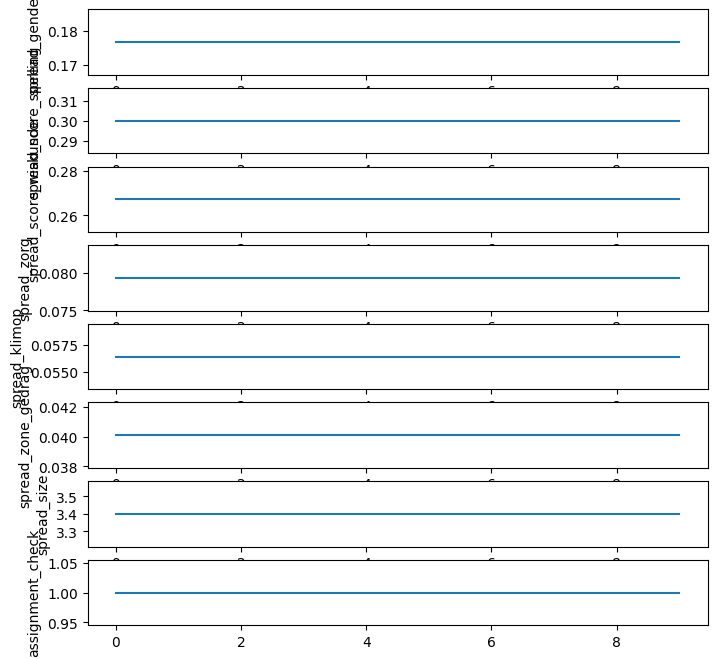

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=len(pop1.summary()))
fig.set_size_inches(8,8)
for i,summ in enumerate(pop1.summary()):
    y = [gen[summ] for gen in summaries]
    ax[i].plot(y)
    ax[i].set_ylabel(summ)

In [22]:
pop.pareto()

,Individual,spread_gender,spread_score_spelling,spread_score_wiskunde,spread_zorg,spread_klimop,spread_zone_gedrag,spread_size,assignment_check
0,<classevy.klas.Plan object at 0x12d1b0610>,0.029412,0.323529,0.357843,0.068627,0.053922,0.029412,5.5,True
1,<classevy.klas.Plan object at 0x12d1d4b90>,0.126984,0.301587,0.06746,0.083333,0.019841,0.035714,2.5,True
2,<classevy.klas.Plan object at 0x12bacbb50>,0.158333,0.4,0.054167,0.145833,0.029167,0.033333,3.5,True
3,<classevy.klas.Plan object at 0x12d1dd2d0>,0.420635,0.392857,0.662698,0.007937,0.111111,0.055556,2.5,True
4,<classevy.klas.Plan object at 0x12d1f6590>,0.276786,0.446429,0.397321,0.107143,0.040179,0.03125,4.5,True
5,<classevy.klas.Plan object at 0x12d1e4050>,0.238095,0.301587,0.388889,0.007937,0.019841,0.055556,2.5,True
6,<classevy.klas.Plan object at 0x12d1b3190>,0.055556,0.210317,0.388889,0.007937,0.111111,0.035714,2.5,True
7,<classevy.klas.Plan object at 0x10e27fd10>,0.215385,0.511538,0.092308,0.207692,0.1,0.038462,1.5,True
8,<classevy.klas.Plan object at 0x12d200510>,0.215385,0.157692,0.269231,0.119231,0.011538,0.038462,1.5,True
9,<classevy.klas.Plan object at 0x12d1e7990>,0.158333,0.270833,0.341667,0.045833,0.029167,0.033333,3.5,True


In [23]:
front = pop.pareto()

In [24]:
goals = pop.goals_names
goals

['spread_gender',
 'spread_score_spelling',
 'spread_score_wiskunde',
 'spread_zorg',
 'spread_klimop',
 'spread_zone_gedrag',
 'spread_size']

In [25]:
front['sum'] = sum([front[col] for col in goals])

In [26]:
front.sort_values('sum')

,Individual,spread_gender,spread_score_spelling,spread_score_wiskunde,spread_zorg,spread_klimop,spread_zone_gedrag,spread_size,assignment_check,sum
11,<classevy.klas.Plan object at 0x11fc272d0>,0.219697,0.238636,0.231061,0.193182,0.090909,0.045455,0.5,True,1.518939
19,<classevy.klas.Plan object at 0x129a4f610>,0.215385,0.157692,0.269231,0.119231,0.011538,0.038462,1.5,True,2.311538
8,<classevy.klas.Plan object at 0x12d200510>,0.215385,0.157692,0.269231,0.119231,0.011538,0.038462,1.5,True,2.311538
7,<classevy.klas.Plan object at 0x10e27fd10>,0.215385,0.511538,0.092308,0.207692,0.1,0.038462,1.5,True,2.665385
1,<classevy.klas.Plan object at 0x12d1d4b90>,0.126984,0.301587,0.06746,0.083333,0.019841,0.035714,2.5,True,3.134921
6,<classevy.klas.Plan object at 0x12d1b3190>,0.055556,0.210317,0.388889,0.007937,0.111111,0.035714,2.5,True,3.309524
5,<classevy.klas.Plan object at 0x12d1e4050>,0.238095,0.301587,0.388889,0.007937,0.019841,0.055556,2.5,True,3.511905
3,<classevy.klas.Plan object at 0x12d1dd2d0>,0.420635,0.392857,0.662698,0.007937,0.111111,0.055556,2.5,True,4.150794
2,<classevy.klas.Plan object at 0x12bacbb50>,0.158333,0.4,0.054167,0.145833,0.029167,0.033333,3.5,True,4.320833
12,<classevy.klas.Plan object at 0x12d1e70d0>,0.225,0.079167,0.425,0.045833,0.066667,0.033333,3.5,True,4.375


In [27]:
best_plan = front.sort_values('sum').iloc[0].values[0]

In [28]:
best_plan.classes_gender

[0.2727272727272727, -0.16666666666666666]

In [29]:
students['gender'].mean()

0.043478260869565216

In [30]:
best_plan.classes[0].print_names()

Younes
Dieuwke
Arthur
Ties
Anant
Leon
Sterre
Ayline
Elena
Elias
Ben


In [31]:
best_plan.classes[1].print_names()

Wout
Amelia
Anna
Helena
Denzel
Jazzlyn
Jennifer
Caitlynn
Pifte
Fiene
Sid
Fabrio


In [32]:
best_plan.classes_size

[11, 12]

In [33]:
best_plan.classes_gender

[0.2727272727272727, -0.16666666666666666]

In [34]:
best_plan.classes_score_wiskunde

[2.4545454545454546, 2.9166666666666665]

In [35]:
best_plan.check_assignment()

True

In [36]:
best_plan.students

,name,gender,score_spelling,score_wiskunde,zorg,klimop,zone_gedrag,not_together,together,preferences,options,dna_assignment,final_assignment,pref_satisfied
number,,,,,,,,,,,,,,
1,Younes,1,5,5,1,0,0,"(4,)","(2,)","(3, 6, 17)",[0],0,0.0,2.0
2,Dieuwke,-1,4,4,0,0,0,(),"(1,)","(5, 9, 20)",[0],0,0.0,2.0
3,Arthur,1,5,1,1,0,0,"(6,)",(),"(2, 1, 21)",[0],0,0.0,2.0
4,Wout,1,2,1,0,0,0,"(1,)",(),"(5, 6, 7)",[1],0,1.0,3.0
5,Amelia,-1,2,4,0,0,0,(),(),"(6, 7, 22)","[0, 1]",1,1.0,2.0
6,Anna,-1,3,1,0,0,0,"(3, 8)",(),"(12, 5, 23)",[],0,1.0,2.0
7,Helena,-1,2,2,0,0,0,(),"(8,)","(8, 17, 23)",[1.0],1,1.0,1.0
8,Denzel,1,3,2,0,0,0,"(6,)","(7,)","(9, 20, 14)",[1],0,1.0,1.0
9,Ties,1,5,3,1,0,0,(),(),"(10, 18, 19)","[0, 1]",0,0.0,2.0


In [37]:
pop.summary()

{'spread_gender': 0.17667956226779757,
 'spread_score_spelling': 0.30007915083282727,
 'spread_score_wiskunde': 0.2671945497313145,
 'spread_zorg': 0.07932235044367399,
 'spread_klimop': 0.056415337113866516,
 'spread_zone_gedrag': 0.040089985586309114,
 'spread_size': 3.4,
 'assignment_check': 1.0}

In [38]:
best_plan.spread_zone_gedrag

0.045454545454545456

In [39]:
best_plan.print_summary()

Mean classes_gender per class: [0.2727272727272727, -0.16666666666666666]
Spread of mean spread_gender over classes: 0.21969696969696967
Mean classes_score_spelling per class: [3.727272727272727, 3.25]
Spread of mean spread_score_spelling over classes: 0.23863636363636354
Mean classes_score_wiskunde per class: [2.4545454545454546, 2.9166666666666665]
Spread of mean spread_score_wiskunde over classes: 0.23106060606060597
Mean classes_zorg per class: [0.6363636363636364, 0.25]
Spread of mean spread_zorg over classes: 0.19318181818181818
Mean classes_klimop per class: [0.18181818181818182, 0.0]
Spread of mean spread_klimop over classes: 0.09090909090909091
Mean classes_zone_gedrag per class: [0.09090909090909091, 0.0]
Spread of mean spread_zone_gedrag over classes: 0.045454545454545456
